In [1]:
from dsoclasses.orbits import sp3c, interpolator
from dsoclasses.geodesy import transformations
from dsoclasses.gnss import systems as gs
from dsoclasses.rinex.gnss.rinex import GnssRinex, fetch, fetchv
from dsoclasses.troposphere import gmf, gpt3
from dsoclasses.time.pyattotime import at2pt, fsec2asec
import attotime, datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# set the name of the (GNSS) RINEX file to use
rinex_fn = "../../data/DYNG00GRC_R_20240010000_01D_30S_MO.rnx"
# set the name of the Sp3 file for the same satellite, covering the same day
sp3_fn = "../../data/COD0MGXFIN_20240010000_01D_05M_ORB.SP3"

f1 = gs.GPS_L1_FREQ # MHz
f2 = gs.GPS_L2_FREQ # MHz
fac = f1*f1 - f2*f2

# Γεωμετρική απόσταση δορυφόρου-δέκτη
def geometric_range(rsat, rrec): return np.linalg.norm(rsat-rrec)

# Συν/νες δορυφόρου την εποχή εκπομπής
def sat_at_emission_time(rsta, t_reception, interpolator, sat):
    t_emission = t_reception
    x, y, z, clk = interpolator.sat_at(sat, t_emission)
    while True:
        r = geometric_range(np.array((x,y,z)), rsta)
        dt = r / gs.C
        t_emission = t_reception - fsec2asec(dt)
        xnew, ynew, znew, clk = interpolator.sat_at(sat, t_emission)
        if abs(xnew-x)<.1 and abs(ynew-y)<.1 and abs(znew-z)<.1:
            return xnew, ynew, znew, clk, dt
        else:
            x=xnew; y=ynew; z=znew;

# Καρτεσιανές σε αζιμούθιο, γωνία ύψους και απόσταση
def azele(R, rsat, rsta):
    enu = R @ (rsat - rsta)
    r  = np.linalg.norm(enu)
    az = np.arctan2(enu[0], enu[1])
    el = np.arcsin(enu[2] / r)
    return r, az, el

# Υπολογισμός ZHD και προσεγγιστικού ZWD με χρήση μετεωρολογικών δεδομένων GPT3
def static_tropo_delay(t, lat, lon, hgt):
    meteo = gpt3.gpt3(t, lon, lat, hgt, "../../data/gpt3_5.grd")
    zhd = gpt3.saastamoinen_zhd(lat, hgt, meteo['p'])
    zwd = gpt3.askne_zwd(meteo['e'], meteo['Tm'], meteo['la'])
    return zhd, zwd

# Υπολογισμός καθυστέρησης λόγω τροπόσφαιρας με χρήση του Global Mapping Function (gmf)
def tropo_delay(t, lat, lon, hgt, el, zhd, zwd):
    gmfh, gmfw = gmf.gmf(t, lat, lon, hgt, np.pi/2-el)
    return zhd * gmfh + zwd * gmfw

# Παρεμβολή για τις τροχιές
intrp = interpolator.Sp3Interpolator(sp3_fn, ['G'], 3600, 10, 'CubicSpline', True, ['M', 'E'])
# Αρχικοποίηση του αντικειμένου GnssRinex
rnx = GnssRinex(rinex_fn)
# προσεγγιστικές συν/νες δέκτη (από RINEX)
rsta = np.array(rnx.approx_cartesian())
# Μετατροπή σε ελλειψοειδείς συν/νες (δέκτης)
lat, lon, hgt = transformations.car2ell(rsta[0], rsta[1], rsta[2])
# Πίνακας στροφής (x, y, z) -> (e, n, u)
Rt = transformations.geodetic2lvlh(lat, lon)
R = Rt.transpose()

Skipping sp3 record for satellite G01: missing clock value ([nan])
Skipping sp3 record for satellite G02: missing clock value ([nan])
Skipping sp3 record for satellite G03: missing clock value ([nan])
Skipping sp3 record for satellite G04: missing clock value ([nan])
Skipping sp3 record for satellite G05: missing clock value ([nan])
Skipping sp3 record for satellite G06: missing clock value ([nan])
Skipping sp3 record for satellite G07: missing clock value ([nan])
Skipping sp3 record for satellite G08: missing clock value ([nan])
Skipping sp3 record for satellite G09: missing clock value ([nan])
Skipping sp3 record for satellite G10: missing clock value ([nan])
Skipping sp3 record for satellite G11: missing clock value ([nan])
Skipping sp3 record for satellite G12: missing clock value ([nan])
Skipping sp3 record for satellite G13: missing clock value ([nan])
Skipping sp3 record for satellite G14: missing clock value ([nan])
Skipping sp3 record for satellite G15: missing clock value ([n

## Γραφική Παράσταση παρατήρησης φάσης L1 για τον δορυφόρο G09

Παρακάτω, θα απεικονίσουμε τις καταγεγραμμένες παρατηρήσεις της φάσης L1 όπως καταγράφονται στο αρχείο RINEX.

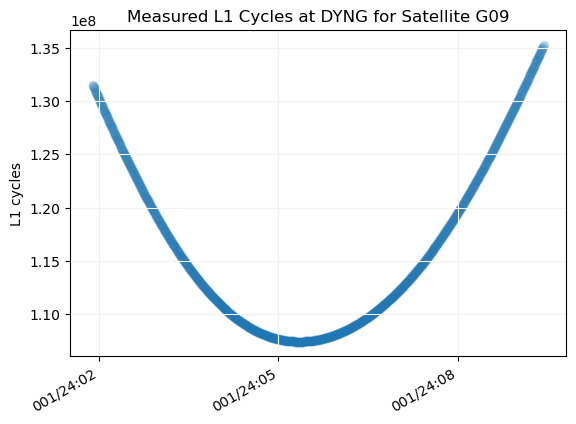

In [2]:
# κενές λίστες για τον χρόνο και την L1
epochs = []; l1s = [];

for block in rnx:
    t = block.t()
    for sat, obs in block.filter_satellite_system("gps", False):
        if sat == 'G09':
            try:
                # ως L1 θα πάρουμε οποιαδήποτε παρατήρηση από τις 'L1W', 'L1C', 'L1X', 
                # με αύξουσα σειρά προτεραιότητας; σε [cycles]
                l1 = fetchv(obs, 'L1W', 'L1C', 'L1X')
                epochs.append(at2pt(t)); l1s.append(l1);
            except:
                pass

# Γραφική αναπαράσταση (χρόνος - L1 σε κύκλους)
fig, ax = plt.subplots()
ax.scatter(epochs, l1s, alpha=0.2)
ax.grid(color='0.95')
plt.ylabel("L1 cycles")
plt.title("Measured L1 Cycles at {:} for Satellite {:}".format(rnx.marker_name, 'G09'))
hours = mdates.HourLocator(interval = 3)
h_fmt = mdates.DateFormatter('%j/%y:%H')
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
fig.autofmt_xdate()
plt.show()

In [3]:
# μήκος κύματος της συχνότητας L1
wl1 = (gs.C / f1) * 1e-6
print("Frequency of L1 is {:.2f}[MHz]".format(f1))
print("Wavelength of L1 frequency is: {:.1f}[cm]".format(wl1 * 1e2))

Frequency of L1 is 1575.42[MHz]
Wavelength of L1 frequency is: 19.0[cm]


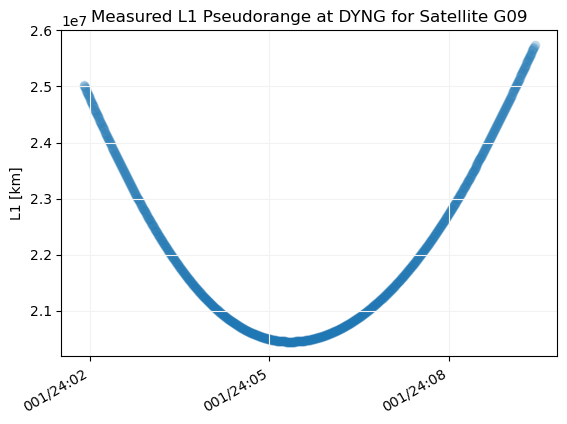

In [4]:
# Γραφική αναπαράσταση (χρόνος - L1 σε km)
fig, ax = plt.subplots()
ax.scatter(epochs, [ l*wl1 for l in l1s], alpha=0.2)
ax.grid(color='0.95')
plt.ylabel("L1 [km]")
plt.title("Measured L1 Pseudorange at {:} for Satellite {:}".format(rnx.marker_name, 'G09'))
hours = mdates.HourLocator(interval = 3)
h_fmt = mdates.DateFormatter('%j/%y:%H')
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
fig.autofmt_xdate()
plt.show()

## Εύρεση Απωλειών Κύκλων

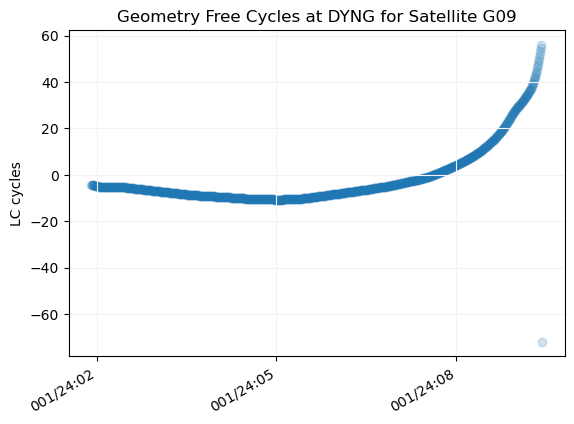

In [6]:
# κενές λίστες για τον χρόνο και την L1
epochs = []; lcs = [];

for block in rnx:
    t = block.t()
    for sat, obs in block.filter_satellite_system("gps", False):
        if sat == 'G09':
            try:
                l1 = fetchv(obs, 'L1W', 'L1C', 'L1X')
                l2 = fetchv(obs, 'L2W', 'L2C', 'L2D', 'L2P', 'L2X')
                lc = l1 - (f1/f2) * l2
                epochs.append(at2pt(t)); lcs.append(lc);
            except:
                pass

# Γραφική αναπαράσταση (χρόνος - LC σε κύκλους)
fig, ax = plt.subplots()
ax.scatter(epochs, lcs, alpha=0.2)
ax.grid(color='0.95')
plt.ylabel("LC cycles")
plt.title("Geometry Free Cycles at {:} for Satellite {:}".format(rnx.marker_name, 'G09'))
hours = mdates.HourLocator(interval = 3)
h_fmt = mdates.DateFormatter('%j/%y:%H')
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
fig.autofmt_xdate()
plt.show()

In [11]:
def find_cycle_slips(epochs, lc, fit_pts=12, poly_order=2):
    mark = []
    cc   = []
    def pnguess(coeffs, dt): return np.poly1d(np.flip(coeffs))(dt)
    def restart(index, mark_cc=False):
        if mark_cc:
            # print("Introducing cc at {:}".format(epochs[index].strftime("%H:%M:%S")))
            cc.append(epochs[index])
        start_index = index
        x =  t[start_index:start_index+fit_pts]
        y = lc[start_index:start_index+fit_pts]
        assert len(x) == fit_pts
        c, stats = np.polynomial.polynomial.polyfit(x, y, poly_order, None, True)
        # print(len(x), stats)
        # print("ressum = {:.3f} sqrt(resum) = {:.3f} sqrt(resum/n) = {:.3f}".format(rsum2, np.sqrt(rsum2), np.sqrt(rsum2/len(x))))
        residuals = stats[0][0]
        return start_index, c, np.sqrt(residuals)
        
    # first, transform epochs to seconds since first epoch
    t = [0.] * len(epochs)
    for i, ei in enumerate(epochs[1:]): t[i+1] = float((ei - epochs[0]).total_nanoseconds()) * 1e-9
    start_index, c, sigma = restart(0, True)
    # print("Starting obs from {:} to {:}".format(epochs[start_index].strftime("%H:%M:%S"), epochs[fit_pts-1].strftime("%H:%M:%S")))
    while start_index + fit_pts < len(epochs):
        pnext = start_index + fit_pts
        # if too far away, introcude cc and restart
        if t[pnext] - t[pnext-1] > 5. * 30.: 
            start_index, c, sigma = restart(pnext, True)
        else:
            guess = pnguess(c, t[pnext])
            res   = abs(guess - lc[pnext])
            #print("Trying next obs at {:}, value is {:.3f} expected {:.3f} s0={:.3f} dt={:.1f}".format(epochs[pnext].strftime("%H:%M:%S"), lc[pnext], guess, sigma, t[pnext] - t[pnext-1]))
            if res*res >= 3. * sigma:
                # try next point (if any)
                pnextp1 = pnext + 1
                if pnextp1 >= len(epochs):
                    mark.append(epochs[pnext])
                    break
                guessp1 = pnguess(c, t[pnextp1])
                resp1   = abs(guessp1 - lc[pnextp1])
                if resp1*resp1 < 3. * sigma:
                    # pnext is an outlier; ignore and move on
                    mark.append(epochs[pnext])
                    print("Marking outlier at {:}".format(epochs[pnext].strftime("%H:%M:%S")))
                    start_index += 2
                    x =  t[start_index:pnext]  + t[pnextp1:start_index+fit_pts+1]
                    y =  lc[start_index:pnext] + lc[pnextp1:start_index+fit_pts+1]
                    c, stats = np.polynomial.polynomial.polyfit(x, y, poly_order, None, True)
                    sigma = (stats[0])[0] #/ len(x)
                    assert len(x) == fit_pts
                else:
                    start_index, c, sigma = restart(pnext, True)
            else:
                start_index += 1
                start_index, c, sigma = restart(start_index)
    return mark, cc

In [12]:
## 8, 10, 14, 17, 20, 22, 23

epochs = []; lcs = [];
for block in rnx:
    t = block.t()
    for sat, obs in block.filter_satellite_system("gps", False):
        if sat == "G10":
            try:
                l1 = fetch(obs, 'L1W', 'L1C', 'L1X')['value']
                l2 = fetch(obs, 'L2W', 'L2C', 'L2D', 'L2P', 'L2X')['value']
                lc = l1 - (f1/f2) * l2
                epochs.append(t); lcs.append(lc);
            except:
                pass
m, cc = find_cycle_slips(epochs, lcs)

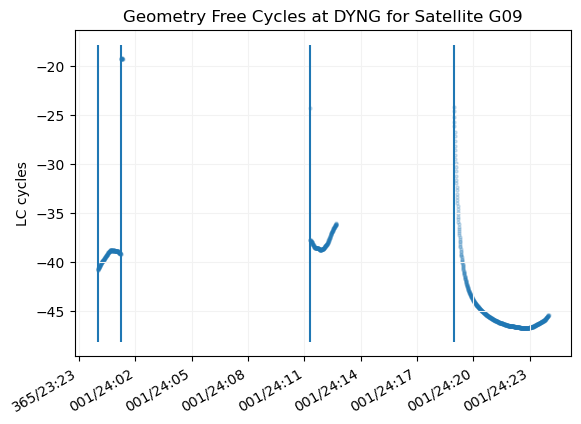

In [13]:
# Γραφική αναπαράσταση (χρόνος - LC σε κύκλους)
fig, ax = plt.subplots()
ax.scatter([at2pt(t) for t in epochs], lcs, alpha=0.2, s=20, marker=".")
# plt.xlim(right=datetime.datetime(2024,1,1,3,50,0))
# plt.xlim(right=datetime.datetime(2024,1,1,3,50,0))
# plt.ylim(-10.,-4.) G21
# plt.xlim(left=datetime.datetime(2024,1,1,2,30,0))
# plt.xlim(right=datetime.datetime(2024,1,1,3,30,0))
# plt.ylim(-19, -16) #G01
b, t = plt.ylim()
ax.vlines(cc, b, t)
ax.grid(color='0.95')
plt.ylabel("LC cycles")
plt.title("Geometry Free Cycles at {:} for Satellite {:}".format(rnx.marker_name, 'G09'))
hours = mdates.HourLocator(interval = 3)
h_fmt = mdates.DateFormatter('%j/%y:%H')
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
fig.autofmt_xdate()
plt.show()

In [14]:
cc = {}
for isat in range(1,33):
    psat = "G{:02d}".format(isat)
    epochs = []; lcs = [];
    for block in rnx:
        t = block.t()
        for sat, obs in block.filter_satellite_system("gps", False):
            if sat == "G10":
                try:
                    l1 = fetch(obs, 'L1W', 'L1C', 'L1X')['value']
                    l2 = fetch(obs, 'L2W', 'L2C', 'L2D', 'L2P', 'L2X')['value']
                    lc = l1 - (f1/f2) * l2
                    epochs.append(t); lcs.append(lc);
                except:
                    pass
    m, cc_sat = find_cycle_slips(epochs, lcs)
    cc['psat'] = cc_sat

In [ ]:
num_ambiguities = 0
for k,v in cc.items(): num_ambiguities += len(v)
clock_poly = 3